In [621]:
import pandas as pd
import numpy as np
filepath = 'train.tsv'
filepath1 = 'dev_part1.tsv'
df = pd.read_csv(filepath, sep='\t', encoding = 'utf-8')
wf = pd.read_csv(filepath1, sep='\t', encoding = 'utf-8')

df.head() 

,PMID,Sentence_ID,Sentence,Gene1|Gene1_ID,Gene1_Index(start|end),Gene2|Gene2_ID,Gene2_Index(start|end),RE_Type
0,24019522,S7,"Notably, all of the H3K36-specific methyltrans...",ASH1L|55870,65|70,HYPB|29072,72|76,NoRE
1,24019522,S7,"Notably, all of the H3K36-specific methyltrans...",ASH1L|55870,65|70,NSD1|64324,78|82,NoRE
2,24019522,S7,"Notably, all of the H3K36-specific methyltrans...",ASH1L|55870,65|70,NSD2|7468,88|92,NoRE
3,24019522,S7,"Notably, all of the H3K36-specific methyltrans...",ASH1L|55870,65|70,Pr-Set7|387893,189|196,NoRE
4,24019522,S7,"Notably, all of the H3K36-specific methyltrans...",ASH1L|55870,65|70,H2A|8337,113|116,Negative_Regulation


In [607]:
sentences = df['Sentence']
target = df['RE_Type']
PMID = df['PMID']
Gene1 = df['Gene1|Gene1_ID']
Gene2 = df['Gene2|Gene2_ID']

In [5]:
import nltk
from nltk.tokenize import word_tokenize

In [7]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

In [608]:
sentences = sentences.str.replace('/', ',')

1.分句

In [512]:
import nltk
from nltk.tokenize import sent_tokenize
sen1=[]
for i in sentences:
    sen1.append(sent_tokenize(i))

In [514]:
sen1[375]

[u'Taken together, these observations indicate that PLD1 is activated by PLCg/PKCa signaling and stimulate Bcl-2 expression through PLA2/Cox2/EP4/PKA/p38MAPK/CREB during neuronal differentiation of rat neural stem cells.']

2.分詞

In [609]:
sen = []
for i in sentences:
    sen.append(word_tokenize(i))

In [503]:
temp1 = []
english_punctuations = [',', '/']
for i in range(0, len(sen)):
    for j in sen[i]:
        if j not in english_stopwords: # 過濾停用詞
            if j not in english_punctuations: # 過濾標點符號
                temp1.append(j)
    sen[i] = temp1
    temp1 = []

將Gene1進行分割 只留下純文字的部分

In [611]:
gene11 = []
gene22 = []
for i in range(0, len(Gene1)):
    gene11.append(Gene1[i].split('|')[0])
    gene22.append(Gene2[i].split('|')[0])

In [612]:
gene1 = []
gene2 = []
for i in range(0, len(Gene1)):
    gene1.append(gene11[i].split('/')[0])
    gene2.append(gene22[i].split('/')[0])

In [613]:
ge1 = []
for i in gene1:
    ge1.append(word_tokenize(i))

In [614]:
ge2 = []
for i in gene2:
    ge2.append(word_tokenize(i))

In [615]:
g1 = []
for i in range(0, len(ge1)):
    if len(ge1[i]) > 1:
        g1.append("".join(ge1[i][0]))
    else:
        g1.append("".join(ge1[i]))

g2 = []
for i in range(0, len(ge2)):
    if len(ge2[i]) > 1:
        g2.append("".join(ge2[i][0]))
    else:
        g2.append("".join(ge2[i]))

將target轉化成數字

In [106]:
label_dict = dict()
label_set = set()
for l in target:
    label_set.add(l)
for ll in label_set:
    label_dict[ll] = len(label_dict)
label_dict_inverse = {v : k for k, v in label_dict.items()}

In [20]:
from keras.utils import to_categorical
target_int = [label_dict[ll] for ll in target]

Using TensorFlow backend.


In [171]:
word = []
train_list = []
for i in range(0, len(target)):
    word.append([Gene1[i], Gene2[i]])
    train_list.append([word[i], target_onehot[i]])
train_list = np.array(train_list)

進行語料庫的建立

In [616]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sen, size = 300, window = 5, min_count = 1)

此函數是用來找前十名最接近輸入詞的詞

In [233]:
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

In [431]:
most_similar(model, ['Notably'])

,Notably,cos
0,microsatellite,0.978024
1,H3K36-specific,0.975455
2,Ugt1,0.970537
3,immunosuppression,0.967056
4,ISGs,0.965125
5,CLL-induced,0.964040
6,scenarios,0.963852
7,behaviour,0.961816
8,interferon-stimulated,0.961166
9,72,0.960318


此函數用來找兩個詞之間的關係（餘弦值）

In [622]:
def similarity(word1, word2):
    try:
        val = model.similarity(word1, word2)
    except:
        val = 0.5
    return val

計算每一組Gene1和Gene2的關係值

In [619]:
cos = []
for i in range(0, len(g1)):
    cos.append(similarity(g1[i], g2[i]))

/Users/laiyanru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [576]:
from sklearn import ensemble, preprocessing, metrics
from sklearn.model_selection import train_test_split
X = cos_new
X = np.array(X)
y = target_new
y = np.array(y)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

# 建立 random forest 模型
forest = ensemble.RandomForestClassifier(n_estimators = 100)
forest_fit = forest.fit(train_X.reshape(-1, 1), train_y)

# 預測"
test_y_predicted = forest.predict(test_X.reshape(-1, 1))

# 績效
accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print(accuracy)

0.7591962404796629


In [577]:
y_null = []
for i in range(0, len(test_y)):
    y_null.append('NoRE')
    
accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print(accuracy)

0.7591962404796629


In [578]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [579]:
print("Random Forests: ")
forest = ensemble.RandomForestClassifier(n_estimators = 100)
accuracy = cross_val_score(forest, X.reshape(-1, 1),y,scoring='accuracy', cv = 5)
print("Accuracy of Random Forests is: " , accuracy.mean())
print("\n\nknn:")
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn,X.reshape(-1, 1),y,cv=5,scoring='accuracy')
print(scores.mean())
print("Accuracy of Knn is: " , scores.mean())
print("\n\nSVM:")
y = target
svm_class = SVC(kernel = 'linear')
accuracy = cross_val_score(svm_class, X.reshape(-1, 1), y, scoring='accuracy', cv = 5).mean()
print("Accuracy of SVM is: " , accuracy)

Random Forests: 
('Accuracy of Random Forests is: ', 0.7061304959146246)


knn:
0.8185082975979894
('Accuracy of Knn is: ', 0.8185082975979894)


SVM:


ValueError: Found input variables with inconsistent numbers of samples: [20568, 27222]

In [216]:
x1 = wf['Gene1|Gene1_ID']
x2 = wf['Gene2|Gene2_ID']
xx1 = []
xx2 = []
for i in range(0, len(x1)):
    xx1.append(x1[i].split('|')[0])
    xx2.append(x2[i].split('|')[0])
cos_dev = []
for i in range(0, len(x1)):
    cos_dev.append(similarity(xx1[i], xx2[i]))

/Users/laiyanru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [175]:
X = cos
X = np.array(X)
y = target
y = np.array(y)

# 建立SVM模型
svm_class = SVC(kernel = 'linear')
svm_class.fit(X.reshape(-1, 1), y)

# 預測
cos_dev = np.array(cos_dev)
predicted = svm_class.predict(cos_dev.reshape(-1, 1))

In [220]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression() #初始化 LR model
X = cos
X = np.array(X)
y = target
y = np.array(y)

classifier.fit(X.reshape(-1, 1), y)
cos_dev = np.array(cos_dev)
predicted = classifier.predict(cos_dev.reshape(-1, 1))

In [165]:
X = vector_plus
X = np.array(X)
y = target
y = np.array(y)

# 建立SVM模型
svm_class = SVC(kernel = 'linear')
svm_class.fit(X, y)

# 預測
cos_dev = np.array(vec_dev)
predicted = svm_class.predict(vec_dev)

寫入檔案

In [223]:
pre = pd.DataFrame({'RE_Type':predicted})

In [224]:
wf = pd.concat([wf, pre], sort = False, axis = 1)

In [225]:
wf.to_csv("prediction.tsv", encoding = 'utf-8', sep = '\t', index = False)

Visualization

In [623]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

/Users/laiyanru/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


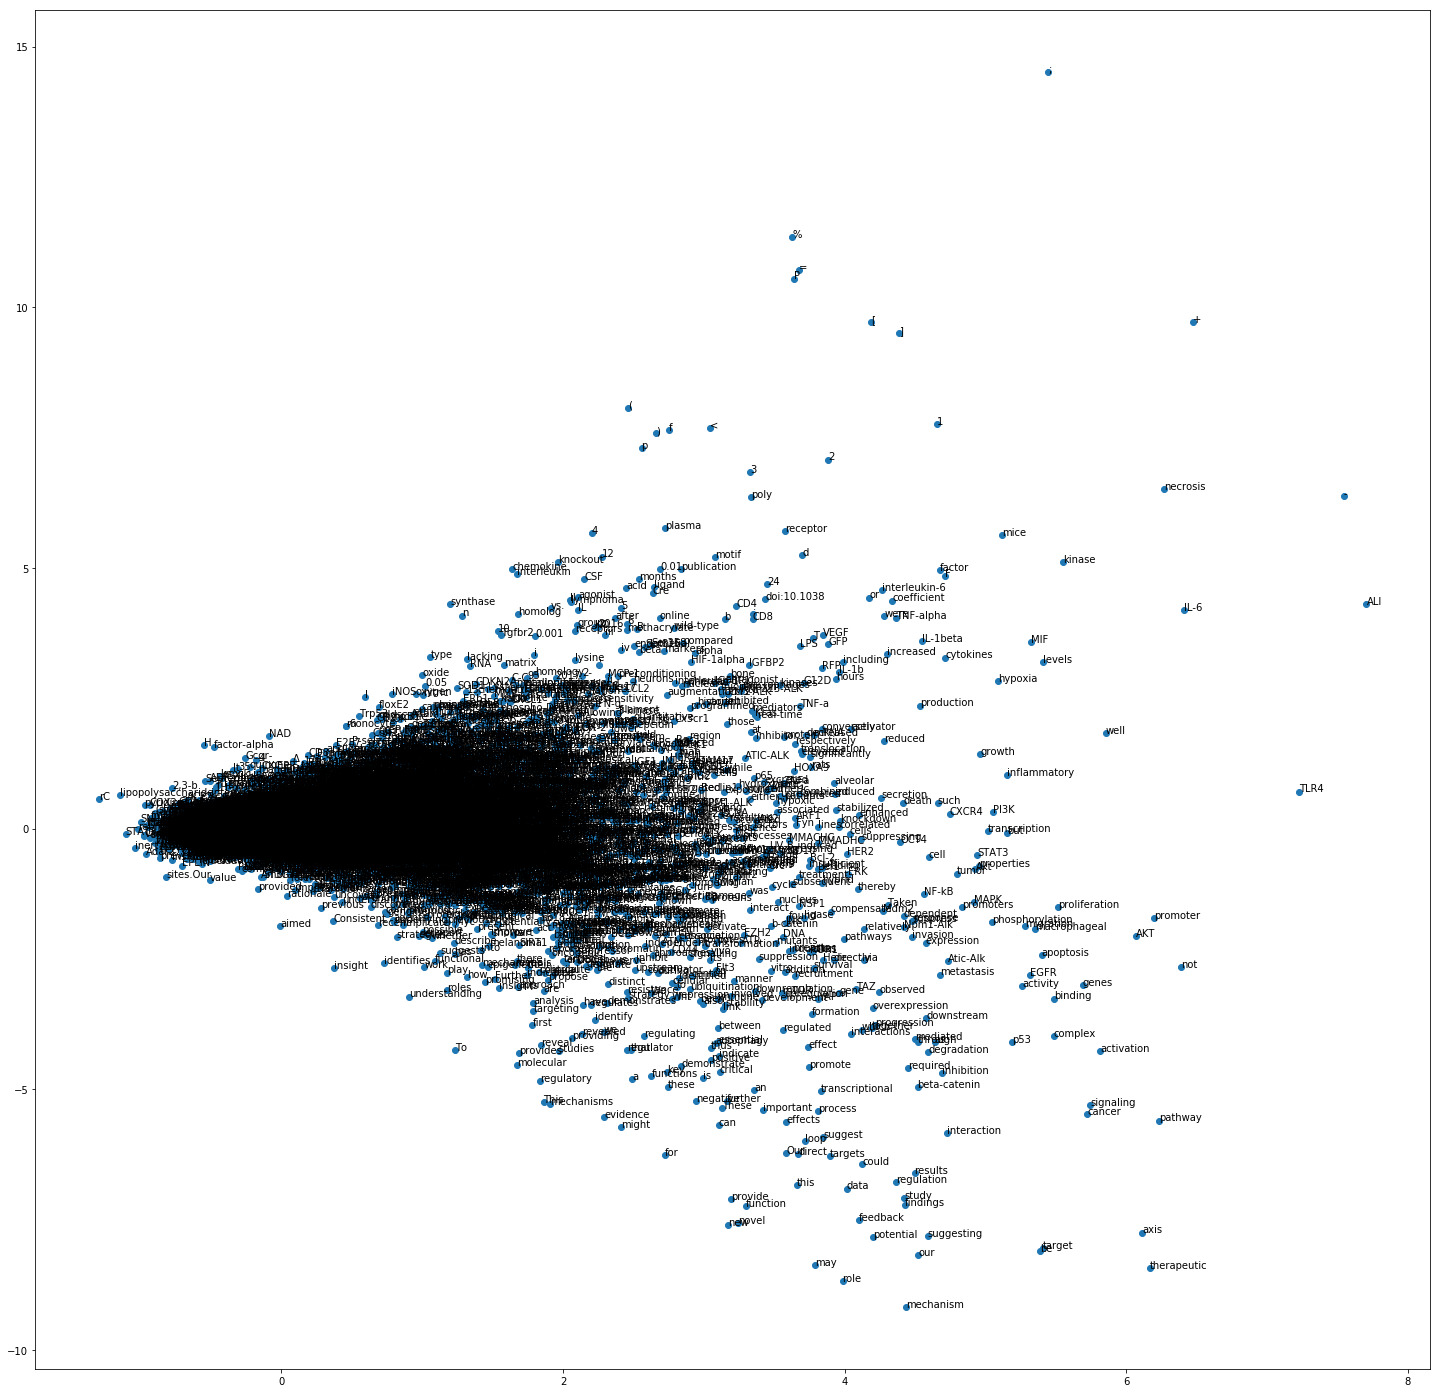

In [624]:
# PCA
plt.figure(figsize=(25, 25))
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
